In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import joblib
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

save_path = "../models/"

In [26]:
X_train = pd.read_csv("../datasets/inputs/train/X_train.csv")
y_train = pd.read_csv("../datasets/inputs/train/y_train.csv")
X_val = pd.read_csv("../datasets/inputs/val/X_val.csv")
y_val = pd.read_csv("../datasets/inputs/val/y_val.csv")
X_test = pd.read_csv("../datasets/inputs/test/X_test.csv")
y_test = pd.read_csv("../datasets/inputs/test/y_test.csv")

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_dataset = data.TensorDataset(
    torch.FloatTensor(X_train.values).to(device),
    torch.FloatTensor(y_train.values).to(device),
)
val_dataset = data.TensorDataset(
    torch.FloatTensor(X_val.values).to(device),
    torch.FloatTensor(y_val.values).to(device),
)
test_dataset = data.TensorDataset(
    torch.FloatTensor(X_test.values).to(device),
    torch.FloatTensor(y_test.values).to(device),
)

batch_size = 256
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

Using device: cuda


In [87]:
class NeuralNetwork(nn.Module):
    def __init__(
        self,
        max_width=1024,
        lr=0.001,
        dropout_rate=0.3,
        weight_decay=1e-4,
        patience=10,
        min_delta=0.0,
    ):
        super(NeuralNetwork, self).__init__()
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

        self.input = nn.Linear(326, max_width)
        self.fc1 = nn.Linear(max_width, max_width // 2)
        self.fc2 = nn.Linear(max_width // 2, max_width // 4)
        self.fc3 = nn.Linear(max_width // 4, max_width // 8)
        self.output = nn.Linear(max_width // 8, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.criterion = nn.MSELoss()
        self.losses = {"train": [], "val": []}
        self.to(device)

        # Early stopping parameters
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = float("inf")
        self.counter = 0
        self.best_model_state = None

    def forward(self, x):
        x = self.input(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.output(x)
        return x

    def train_step(self, x, y):
        predictions = self(x)
        loss = self.criterion(predictions, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def fit(self, train_loader, val_loader, epochs=10):
        for _ in tqdm(range(epochs), desc="Training", unit="epoch"):
            total_loss = 0
            num_batches = 0
            for x_batch, y_batch in train_loader:
                loss = self.train_step(x_batch, y_batch)
                total_loss += loss
                num_batches += 1
            self.losses["train"].append(total_loss / num_batches)

            # Early stopping
            val_loss = self.evaluate(val_loader)
            if val_loss < self.best_val_loss - self.min_delta:
                self.best_val_loss = val_loss
                self.counter = 0
                self.best_model_state = self.state_dict().copy()
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.load_state_dict(self.best_model_state)
                    break

        return self.losses

    def evaluate(self, val_loader):
        self.eval()
        total_val_loss = 0
        num_batches = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                predictions = self(x_batch)
                loss = self.criterion(predictions, y_batch)
                total_val_loss += loss.item()
                num_batches += 1
        avg_val_loss = total_val_loss / num_batches
        self.losses["val"].append(avg_val_loss)
        return avg_val_loss

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            predictions = self(x)
        return predictions

    def test(self, test_loader):
        X_test, y_test = test_loader.dataset[:][0], test_loader.dataset[:][1]
        self.eval()
        with torch.no_grad():
            predictions = self(X_test)
        return F.mse_loss(predictions, y_test).item()

    def save(self, name):
        joblib.dump(self.state_dict(), save_path + name)

    def load(self, name):
        self.load_state_dict(joblib.load(save_path + name))

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses["train"], label="Training Loss")
        plt.plot(self.losses["val"], label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Losses")
        plt.legend()
        plt.grid(True)
        plt.show()

Training: 100%|██████████| 10/10 [11:51<00:00, 71.10s/epoch]


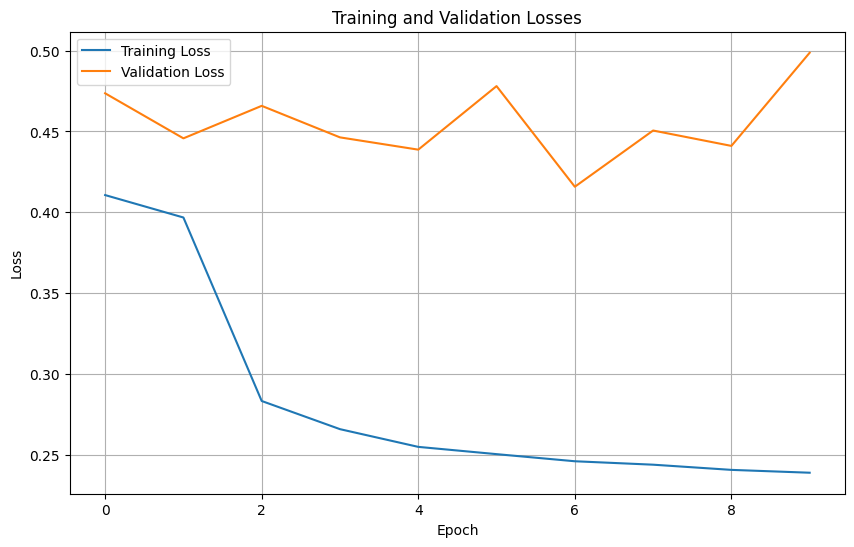

In [ ]:
model = NeuralNetwork()
model.fit(epochs=10)
model.plot_losses()

test_loss = model.test(test_loader)
print(f"Test loss: {test_loss}")

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training: 100%|██████████| 10/10 [02:32<00:00, 15.25s/epoch]


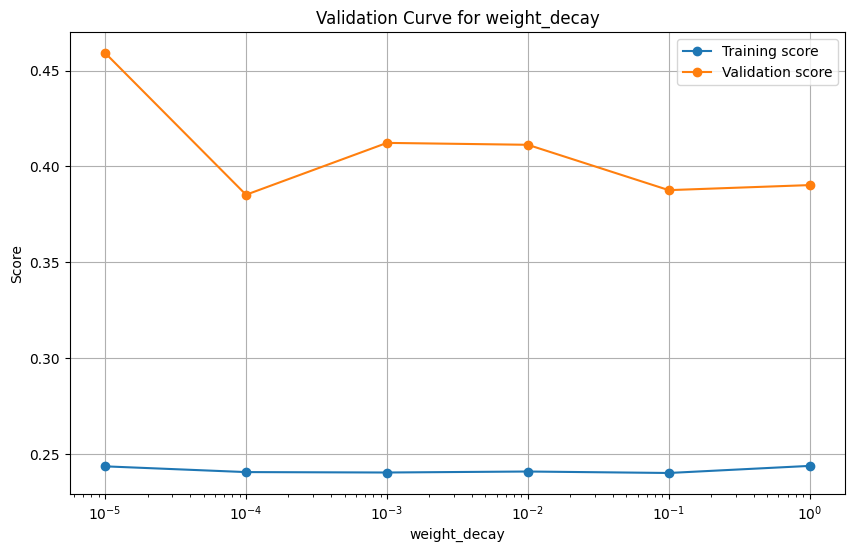

In [85]:
def plot_validation_curve(
    train_loader,
    val_loader,
    param_name="weight_decay",
    param_range=np.logspace(-5, 0, 6),
    epochs=10,
):
    train_scores, val_scores = [], []

    for param in param_range:
        current_model = NeuralNetwork()
        setattr(current_model, param_name, param)
        current_model.fit(train_loader, val_loader, epochs)

        train_scores.append(current_model.losses["train"][-1])
        val_scores.append(current_model.losses["val"][-1])

    plt.figure(figsize=(10, 6))
    plt.semilogx(param_range, train_scores, label="Training score", marker="o")
    plt.semilogx(param_range, val_scores, label="Validation score", marker="o")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.title(f"Validation Curve for {param_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_validation_curve(
    train_loader,
    val_loader,
    param_name="weight_decay",
    param_range=np.logspace(-5, 0, 6),
)

In [86]:
plot_validation_curve(
    train_loader, val_loader, param_name="dropout_rate", param_range=np.linspace(0, 0.5, 6)
)

Training:  20%|██        | 2/10 [00:29<01:58, 14.83s/epoch]

In [ ]:
def plot_learning_curve(
    train_loader, val_loader, train_sizes=np.linspace(0.1, 1.0, 5), epochs=10
):
    train_scores, val_scores = [], []

    for size in train_sizes:
        n_samples = int(len(train_loader.dataset) * size)
        indices = torch.randperm(len(train_loader.dataset))[:n_samples]
        subset = torch.utils.data.Subset(train_loader.dataset, indices)
        subset_loader = torch.utils.data.DataLoader(
            subset, batch_size=train_loader.batch_size
        )

        current_model = NeuralNetwork()
        current_model.fit(subset_loader, val_loader, epochs)

        train_scores.append(current_model.losses["train"][-1])
        val_scores.append(current_model.losses["val"][-1])

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores, label="Training score", marker="o")
    plt.plot(train_sizes, val_scores, label="Validation score", marker="o")
    plt.xlabel("Training set size")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_learning_curve(train_loader, val_loader)